# License

    Jupyter notebook for accessing OpenCL
    Copyright (C) 2015, 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import os
import numpy as np
import pyopencl as cl

from matplotlib import pyplot as plt

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

In [5]:
#Determine which GPU to use
os.environ["PYOPENCL_CTX"] = "1"

#Create OpenCL context
cl_ctx = cl.create_some_context()

print("Using ", cl_ctx.devices[0].name)

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

Using  Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz


In [7]:
%%cl_kernel # it says 'Interpret this cell as the kernel'
# We need to change it for 2D matrix
__kernel void addKernel(__global float *c, __global const float *a, __global const float *b) {
  int gid = get_global_id(0);  
  c[gid] = a[gid] + b[gid];
}

In [8]:
#Size of our test
n = 50

#Create test input / output data
#NOTE: For matrix addition need to use np.random.random((size)) for 2D
a = np.random.rand(n).astype(np.float32)
b = np.random.rand(n).astype(np.float32)
c = np.empty_like(a)

#Upload data to the device
mf = cl.mem_flags
a_g = cl.Buffer(cl_ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a)
b_g = cl.Buffer(cl_ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b)

#Allocate output data
c_g = cl.Buffer(cl_ctx, mf.WRITE_ONLY, a.nbytes) # I'm allocating the right number of bites, not of elements

#Execute program on device
addKernel(cl_queue, a.shape, None, c_g, a_g, b_g)

#Copy data from device to host
cl.enqueue_copy(cl_queue, c, c_g)

In [9]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [0.4450977  1.5435922  0.613253   0.9571967  0.7160654  0.9061918
 1.3518143  0.72939885 0.7644731  0.34424773 1.3303266  0.23773877
 0.57861704 1.2921455  1.1192107  0.94111913 1.5183527  0.83974516
 0.79609466 0.9835112  0.7616987  0.55344355 1.5348403  1.0508264
 0.88163924 1.5534701  0.9755257  1.0719692  1.2712587  1.6487484
 1.6999147  1.1406562  0.59259963 1.2733294  0.47780174 1.4950477
 1.4874265  0.7925861  1.2926583  1.0168258  1.2447764  0.7256965
 0.9093585  1.6922725  1.0726765  1.1254524  0.32049906 0.40326428
 1.6221714  1.1087648 ]
Ref =  [0.4450977  1.5435922  0.613253   0.9571967  0.7160654  0.9061918
 1.3518143  0.72939885 0.7644731  0.34424773 1.3303266  0.23773877
 0.57861704 1.2921455  1.1192107  0.94111913 1.5183527  0.83974516
 0.79609466 0.9835112  0.7616987  0.55344355 1.5348403  1.0508264
 0.88163924 1.5534701  0.9755257  1.0719692  1.2712587  1.6487484
 1.6999147  1.1406562  0.59259963 1.2733294  0.47780174 1.4950477
 1.4874265  0.7925861  1.2926583 

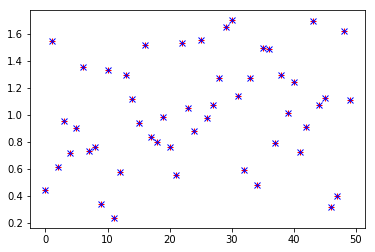

In [10]:
plt.figure()
plt.plot(c, '+r')
plt.plot(c_ref, 'xb')